# Assignment 1: Backpropagation

In [127]:
import numpy as np

In [146]:
inputs = []

for i in range(8):
    input = np.zeros(((8+1),1)) # +1 is the bias
    input[0] = 1 # bias at the beginning of the input
    input[i+1] = 1
    inputs.append(input)

inputs = np.array(inputs*100)
np.random.shuffle(inputs)
inputs

array([[[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [154]:
# Let's discuss wether we want to use global variables, or wanna pass them to functions.
# Especially with the layers. Both works for me but now I changed things and it's messed up :D

W1 = np.random.rand(3, 9)
W2 = np.random.rand(8, 4)
triangles1 = np.zeros((3,9))
triangles2 = np.zeros((8,4))
lr = 0.01 # learning rate
training_set_length = 8

def sigmoid(x):
    return (1/(1 + np.exp(-x)))

def forward_prop(input):
    hidden = sigmoid(np.dot(W1, input))
    hidden = np.insert(hidden,0,1) # insert the bias
    output = sigmoid(np.dot(W2, hidden))
    return(hidden, output)
    
def back_prop(hidden, output, expected):
    one_8 = np.ones(8) # its shape is (8,) and not (1,8), so it works (had some problem with (8,1))
    one_4 = np.ones(4)



    delta3 = output * (one_8 - output) * (output - expected) # deltas in layer 3 (output)
    #         (8x1) * ((8x1) - (8x1))  *  ((8x1) - (8x1))   = (8x1)

    delta2 = hidden * (one_4 - hidden) * np.dot(W2.T, delta3) # deltas in layer 2 (hidden)
    #         (4x1) * ((4x1) - (4x1))  *  ((4x8) . (8x1))   = (4x1)
    #                                          (4x1)
    
    # Would be nicer with another function for it, which has a layer list [input, hidden, output],
    # but I think it's clearer this way (we can change it later).
    for j in range(len(hidden)):
        for i in range(len(output)):
            triangles2[i][j] += hidden[j] * delta3[i] 

    for j in range(len(input)):
        for i in range(len(hidden)-1): # we don't count the bias
            triangles1[i][j] += input[j] * delta2[i] 

def weight_tune(input, hidden, output):
    big_D1 = np.zeros((3,9))
    big_D2 = np.zeros((8,4))
    global W1, W2, triangles1, triangles2

    for j in range(len(hidden)):
        for i in range(len(output)):
            big_D2[i][j] = (triangles2[i][j] + lr * W2[i][j])/training_set_length

    for j in range(len(input)):
        for i in range(len(hidden)-1): # we don't count the bias
            big_D1[i][j] = (triangles1[i][j])/training_set_length

    W1 = W1 - big_D1
    W2 = W2 - big_D2

    triangles1 = np.zeros((3,9))
    triangles2 = np.zeros((8,4)) 
    


    #   Okay, I figured it out. We call forward_prop and back_prop everytime we have a new input,
    #   BUT we don't tune the weights that often. This way it makes sense to add up the triangle[i][j].
    #   We tune the weights after every training set, which contains 'm' input+output.
    #   So I guess the training set is not contain ALL the 8000 inputs we generated.
    #
    #   And we compute big_D: we devide by 'm' so it'd be the average of it and then we subtract
    #   the big_D (which stands for difference I guess, or it's delta again) from the weight.
    #
    #   Am I right with it? My only problem is with the j=0 thing at big_D. I don't get it.


    #   ------------------- MY PREVIOUS SUFFERING WITH THE TRIANGLES --------------------

    #   Yo. How the fuck does the triangle work? I mean let's say there are i x j triangles,
    #   bc I guess that's what ij means. Every triangle is 0 at first and we have this:
    #   triangle = triangle + a_j(l) * d_i(l+1). But if there are i x j triangles then it
    #   happens only once, so it doesn't make any sense.
    #   My guess was what I've done up here, so we'd have a triangle for every neuron.
    #
    #   But then where we compute big_D (Harry Potter reference here hehe) it would have
    #   a point if there would be different triangle for every weight... so...
    #   we compute triangles for weights or neurons?
    #
    #   But then why is it different at the first neurons? So when j = 0, then we don't
    #   compute the learning rate * weight.
    #
    #   Or maybe the combination of both? Compute triangles for neurons, then use one
    #   neuron's triangle for every weight that comes out of it? 
    #
    #   I HAVE NO IDEA

    # new_weight = old_weight - big_D



In [155]:
i = 1
SSE = []
for input in inputs:
    hidden, output = forward_prop(input)
    expected = np.delete(input,0)
    SSE.append(np.sum((output - expected) ** 2))

    back_prop(hidden, output, expected) # we need to delete the bias
    if i % 8 == 0:
        weight_tune(input, hidden, output)
    i+=1

In [152]:
len(SSE)

800

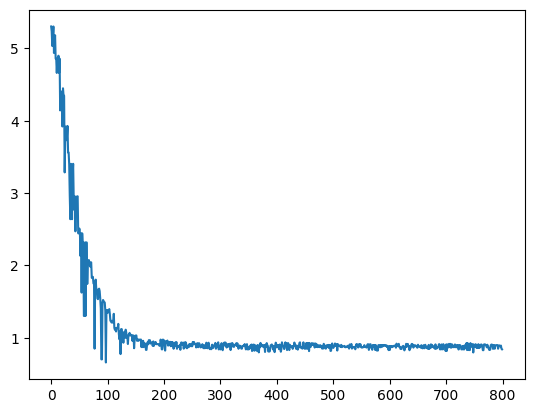

In [156]:
import matplotlib.pyplot as plt
x = []
for i in range(800):
    x.append(i)

plt.plot(x, SSE)

In [158]:
print(inputs[0])

_, output = forward_prop(inputs[0])

print(output)

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]
[0.15057065 0.12871192 0.11811736 0.12836767 0.12119466 0.12977616
 0.14796391 0.10417885]
